In [1]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

### Set up directory
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm

import gymnasium as gym

from llama import get_model_and_tokenizer

In [2]:
model, tokenizer = get_model_and_tokenizer('7b')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## RL helper functions

In [3]:
from rl_utils import gym_generate_random_policy, load_offline_dataset, make_RL_time_serie, icl_prediction, compute_statistics, to_plot_stats 
from rl_disc_utils import gym_generate_deterministic_policy

## DP solvers

In [4]:
from dynamic_programming import compute_optimal_policy

## Generate RL series

In [5]:
def make_RL_time_serie_discrete(
    X: np.array,
    Number_of_steps: int = 200,
    traj_starting_idx: int = 0,
    add_actions: bool = False,
):
    if add_actions:
        episode_time_series = X[traj_starting_idx:traj_starting_idx+Number_of_steps,:2]
    else:
        episode_time_series = X[traj_starting_idx:traj_starting_idx+Number_of_steps,:1]
    time_series = episode_time_series.flatten()
    full_series = ",".join(str(int(x)) if not np.isnan(x) else 'done' for x in time_series)
    print(f"full_series: {full_series[:25]}")
    # Save the generated data to a dictionary
    series_dict = {
        'full_series': full_series,
        'actions': X[traj_starting_idx:traj_starting_idx+Number_of_steps,1:2].flatten()
    }
    return series_dict

def build_transition_matrix(P_true: dict):
    n_states = len(P_true.keys())
    n_actions = len(P_true[0].keys())
    P = np.zeros((n_states, n_actions, n_states))
    R = np.zeros((n_states, n_actions))
    for state in range(n_states):
        for action in range(n_actions):
            for transition in P_true[state][action]:
                proba, next_state, reward, _ = transition
                P[state, action, next_state] = proba
                R[state, action] = reward
    return P, R

def build_baseline_transition_matrix(n_states: int, n_actions: int, states: np.array, actions: np.array, add_actions: bool = False):
    P_baseline = (1/n_states) * np.ones((n_states, n_actions, n_states))
    visited = np.zeros((n_states, n_actions))
    for i in range(len(actions)-1):
        action = actions[i]
        if not np.isnan(action):
            state_index = i if not add_actions else 2*i
            state = int(states[state_index])
            if visited[state, int(action)]==0.0:
                P_baseline[state][int(action)] *= 0.0
            P_baseline[state][int(action)][int(states[i+1 if not add_actions else 2+2*i])] += 1.0
            visited[state, int(action)] = 1.0
    line_sums = np.sum(P_baseline, axis=2)
    non_zero_sums_mask = line_sums <= 1e-3
    new_line_sums = np.where(non_zero_sums_mask, 1.0, line_sums)
    P_baseline /= new_line_sums[...,None]
    return P_baseline

def kl_div(p: np.array,q: np.array):
    KL = np.sum(p * (np.log(p) - np.log(q)))  # check dim
    return KL

def compute_statistics_discrete(series_dict, add_actions: bool = False):
    series = series_dict['full_series'].split(',')
    actions = series_dict['actions']
    probs = series_dict['probs']

    P = series_dict['true_P']
    print(f"true probability matrix P: {P.shape}")

    P_hat = np.zeros_like(P)
    
    mode_arr = []
    discrete_BT_loss = []
    discrete_KL_loss = []
    P_diff = []
    
    for i in range(len(actions)):
        action = actions[i]
        state_index = i if not add_actions else 2*i
        probs_index = 2*i if not add_actions else 2+4*i
        state = int(series[state_index])
        if not np.isnan(action):
            true_proba = P[state][int(action)].flatten()
            predicted_proba = probs[0, probs_index].flatten()
            p_line = P_hat[state][int(action)]
            if np.sum(p_line)==0.0:
                P_hat[state][int(action)] = copy.copy(predicted_proba)
            else:
                P_hat[state][int(action)] = (p_line + copy.copy(predicted_proba)) / 2

            P_diff.append(np.linalg.norm(P-P_hat))
            
            # KL divergence
            discrete_KL_loss.append(kl_div(p=true_proba,q=predicted_proba))
            
            # Bhattacharyya distance
            sqrt_PQ = np.sum(np.sqrt(predicted_proba * true_proba))
            BH = -np.log(sqrt_PQ)
            discrete_BT_loss.append(BH)

            # mode_prediction
            mode_arr.append(np.argmax(predicted_proba))

    series_dict['predicted_P'] = P_hat
            
    # loss_array = np.zeros(full_array[start_idx:].squeeze().shape)
    # # for state in states[[0,1]]:
    # for state in states:
    #     ### add 2 to slice out BOS
    #     pos = np.where(full_array[start_idx:]==state)[0]+2
    #     learned_p_out = probs.squeeze()[start_idx:][pos]
    #     true_p_out = torch.tensor(P[state])
    #     if dist_type == 'KL':
    #     ### KL divergence at each row
    #         KL = torch.sum(true_p_out * (true_p_out.log() - learned_p_out.log()), dim = 1)
    #         dist = KL
    #     else:
    #         ### Bhattacharyya distance at each row
    #         sqrt_PQ = torch.sum(torch.sqrt(learned_p_out * true_p_out), dim = 1)
    #         BH_dist = -torch.log(sqrt_PQ)
    #         dist = BH_dist
        
    #     loss_array[pos-2] = dist.numpy()

    statistics = {
        'mode_arr': np.array(mode_arr),
        'discrete_BT_loss': discrete_BT_loss,
        'discrete_KL_loss': discrete_KL_loss,
        'P_diff': np.array(P_diff)
    }

    return series_dict, statistics

def plot_diff(series_dict, indices: List[int] = [0], add_actions: bool = False):
    series = series_dict['full_series'].split(',')
    actions = series_dict['actions']
    probs = series_dict['probs']
    P = series_dict['true_P']
    for index in indices:
        if (not add_actions) or (index%2 == 0):
            action = actions[index]
            if not np.isnan(action):
                state = int(series[index])
                true_proba = P[state][int(action)].flatten()
                predicted_proba = probs[0, 2*index if not add_actions else 2+4*i].flatten()
                plt.figure(figsize=(15,5))
                n=len(true_proba)
                r = np.arange(n) 
                width = 0.25
                plt.bar(r, true_proba, color = 'b', width = width, edgecolor = 'black',  label='gt')
                plt.bar(r + width, predicted_proba, color = 'orange', width = width, edgecolor = 'black', label='pred')
                plt.legend()
                plt.title(f"index: {index} with state: {state} and action: {action} | KL={kl_div(p=true_proba,q=predicted_proba)}")
                plt.show()
            else:
                print(f"terminal state")
        else:
            print(f"corresponds to action")

In [7]:
N = 1000
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
# env = gym.make('CliffWalking-v0')
# env = gym.make('Taxi-v3')

N_states = env.observation_space.n
state_dim = 1
action_dim = 1
add_actions = False

# -------------------- Compute true transition matrix --------------------
P, R = build_transition_matrix(P_true=env.P)

fixed_random_policy = np.random.randint(low=0, high=env.action_space.n, size=(N_states, ))

expert_policy, iteration = compute_optimal_policy(T=P, R=R, gamma=0.99, algo='VI')
print(f"optimal policy found after {iteration} iterations")

optimal policy found after 69 iterations


In [12]:
policy_type = 'random_fixed'  # 'random_fixed', 'random', 'expert'

# -------------------- Build data from env --------------------
if policy_type == 'random':
    X = gym_generate_random_policy(env=env, Number_of_steps=N)
elif policy_type == 'random_fixed':
    X = gym_generate_deterministic_policy(env=env, policy=fixed_random_policy, Number_of_steps=N)
elif policy_type=='expert':
    X = gym_generate_deterministic_policy(env=env, policy=expert_policy, Number_of_steps=N)
else:
    raise ValueError(f"policy_type {policy_type} not supported!")

# -------------------- Make RL time serie --------------------
series_dict = make_RL_time_serie_discrete(
    X=X,
    Number_of_steps=N,
    traj_starting_idx=0,
    add_actions=add_actions,
)
series_dict['true_P'] = P
P_baseline = build_baseline_transition_matrix(N_states, env.action_space.n, series_dict['full_series'].split(','), series_dict['actions'], add_actions=add_actions)
series_dict['baseline_P'] = P_baseline

# -------------------- ICL prediction using llama3 --------------------
series_dict = icl_prediction(
    model=model, tokenizer=tokenizer, series_dict=series_dict, temperature=1.0, n_states=N_states,
)

# -------------------- Compute statistics of next state --------------------
series_dict, statistics = compute_statistics_discrete(
    series_dict=series_dict,
    add_actions=add_actions,
)

full_series: 0,0,0,1,0,0,1,2,3,2,1,0,1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 7706.25it/s]

true probability matrix P: (16, 4, 16)



/tmp/ipykernel_2993068/2992897627.py:53: RuntimeWarning: divide by zero encountered in log
  KL = np.sum(p * (np.log(p) - np.log(q)))  # check dim
/tmp/ipykernel_2993068/2992897627.py:53: RuntimeWarning: invalid value encountered in multiply
  KL = np.sum(p * (np.log(p) - np.log(q)))  # check dim


norm_baseline: 5.344178888619748


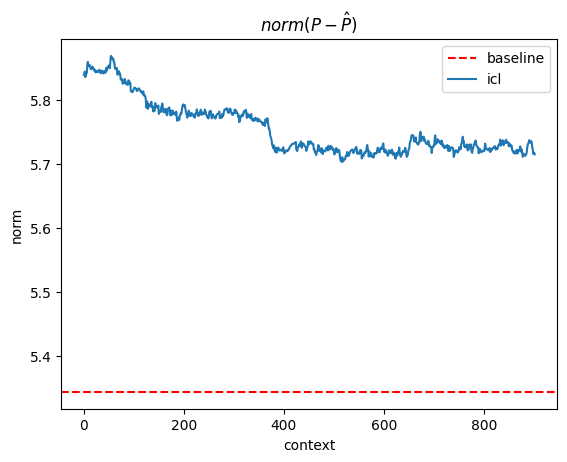

In [13]:
norm_baseline= np.linalg.norm(series_dict['true_P']-series_dict['baseline_P'])
print(f"norm_baseline: {norm_baseline}")
x = np.arange(len(statistics['P_diff']))
plt.figure()
plt.axhline(y=norm_baseline, xmin=x[0], xmax=x[-1], color='r', linestyle='--', label='baseline')
plt.plot(statistics['P_diff'], label='icl')
plt.title(r"$norm(P-\hat{P})$")
plt.xlabel("context")
plt.ylabel("norm")
plt.legend()
plt.show()

In [16]:
series_dict['true_P']

array([[[0.33333333, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.33333333, 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.33333333, 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.33333333, 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.33333333, 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.33333333, 0.        , 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.33333333, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.33333333, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.3

/tmp/ipykernel_1217226/1891197384.py:47: RuntimeWarning: divide by zero encountered in log
  KL = np.sum(p * (np.log(p) - np.log(q)))  # check dim
/tmp/ipykernel_1217226/1891197384.py:47: RuntimeWarning: invalid value encountered in multiply
  KL = np.sum(p * (np.log(p) - np.log(q)))  # check dim


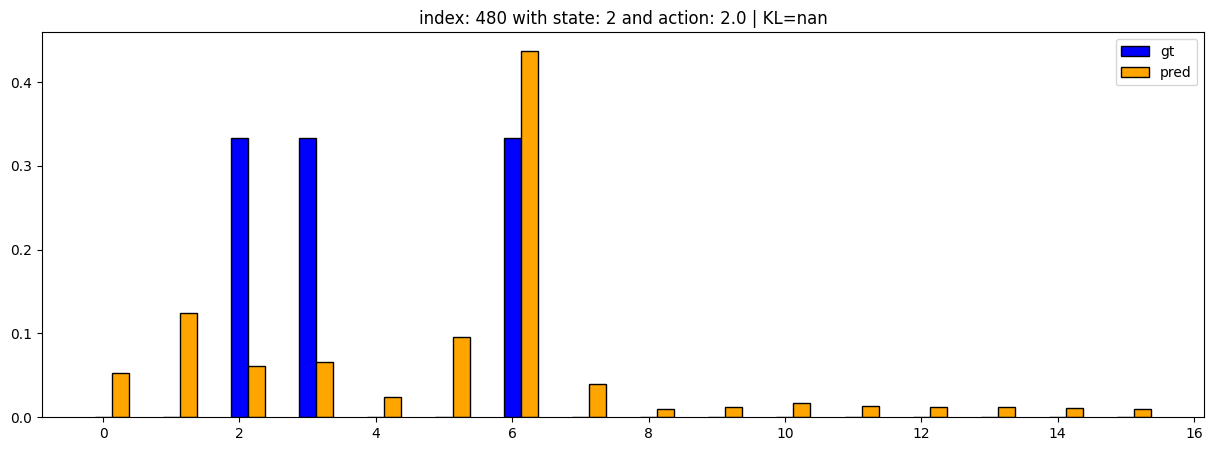

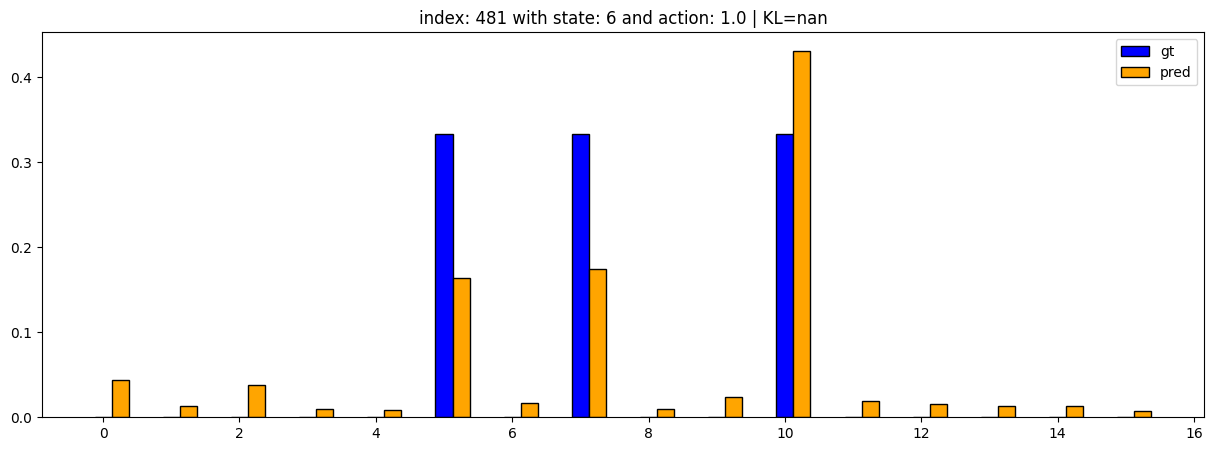

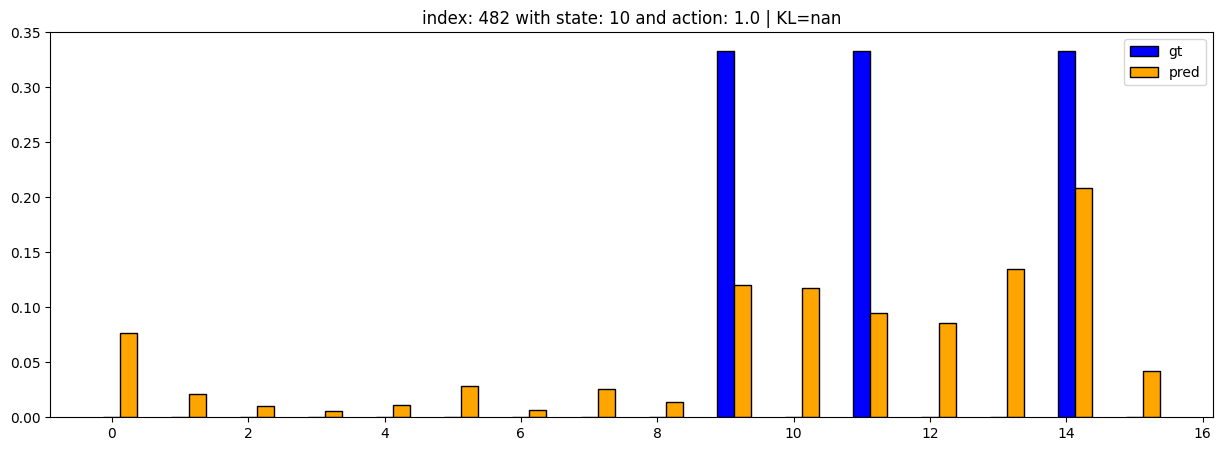

terminal state


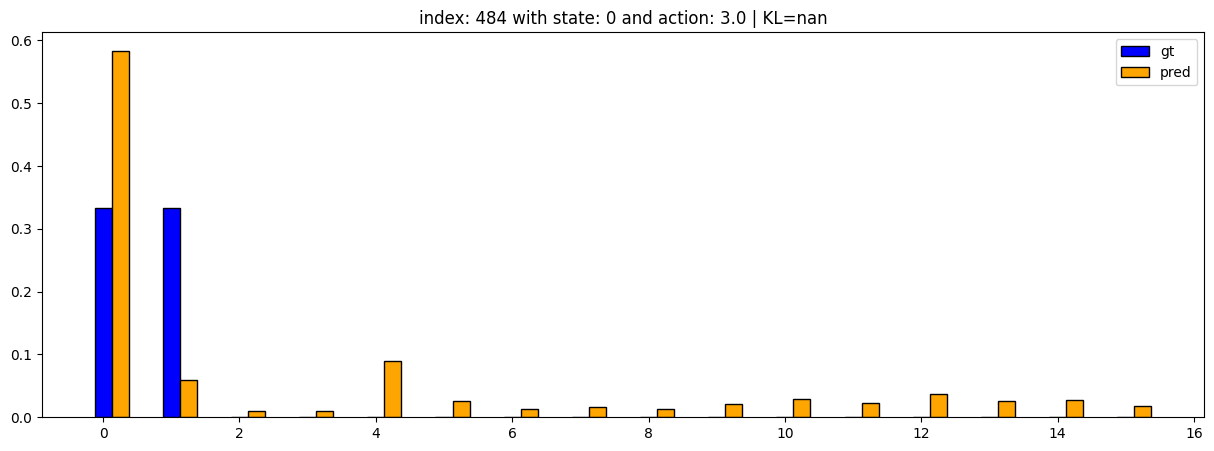

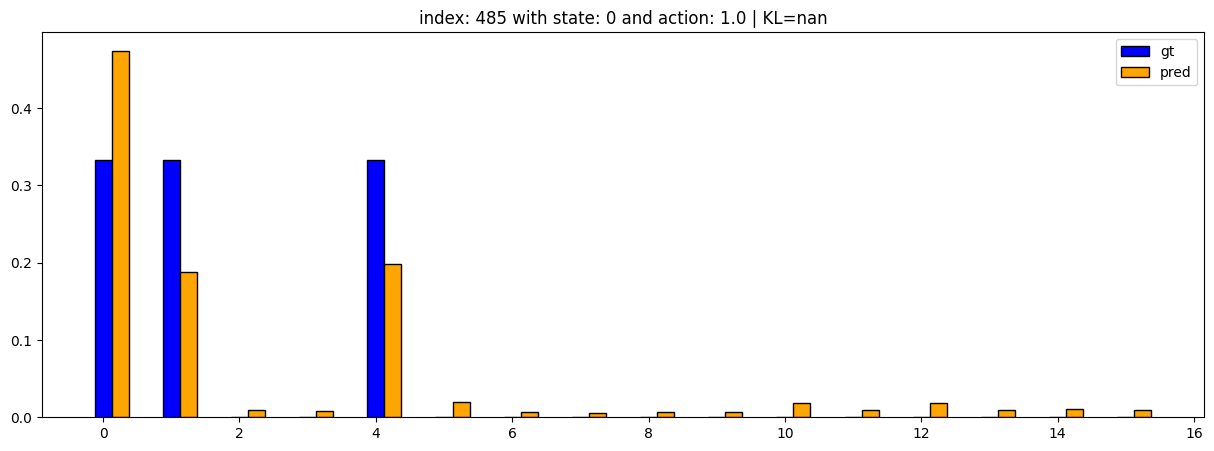

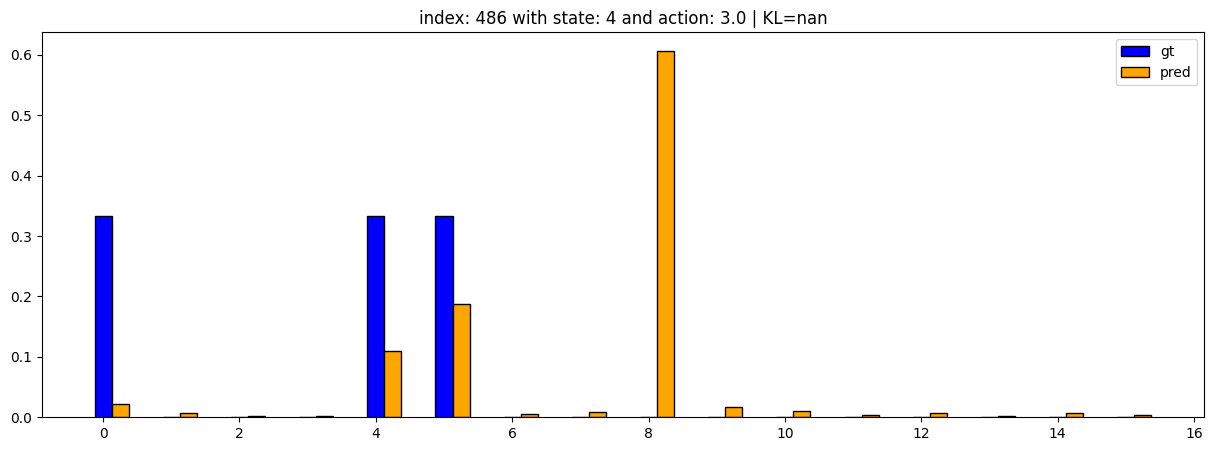

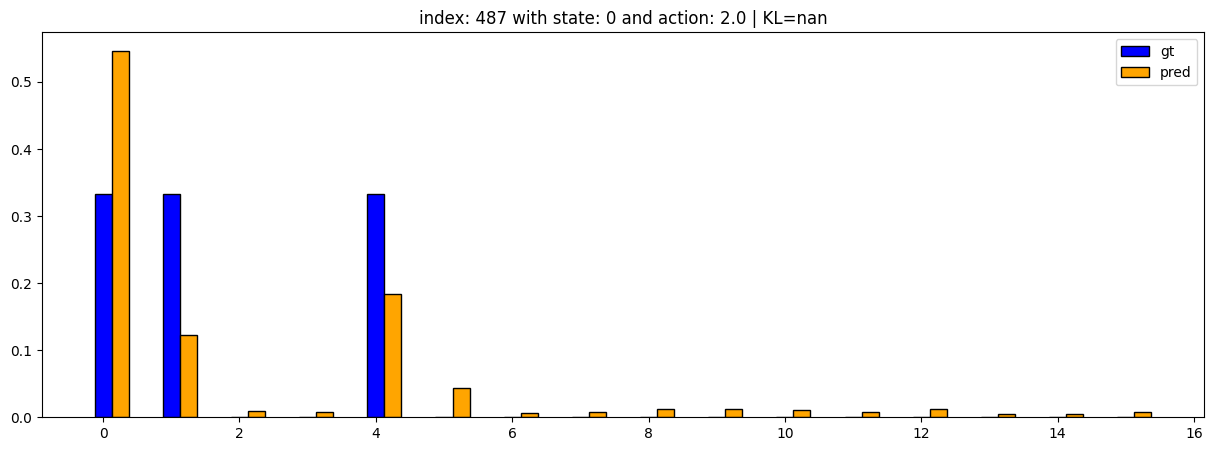

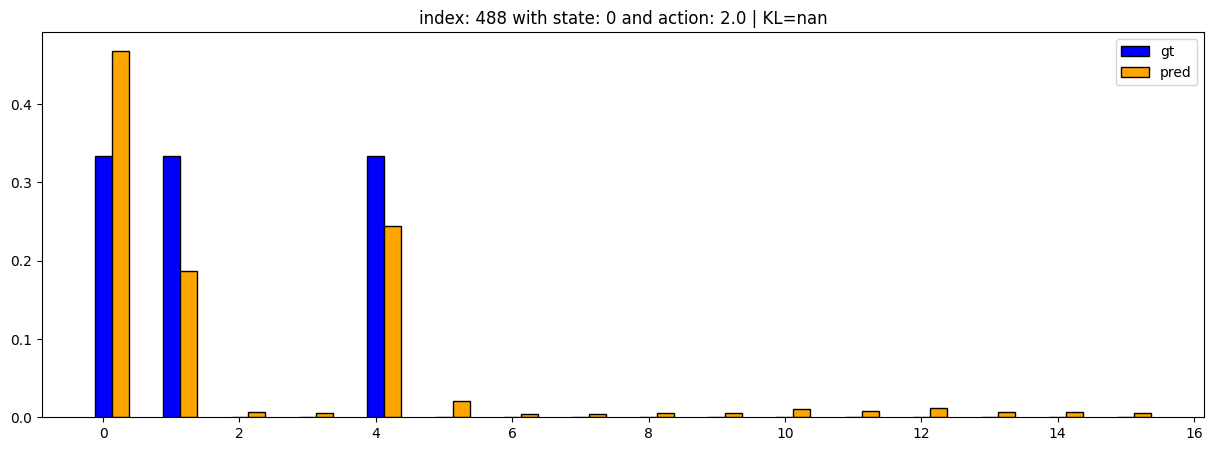

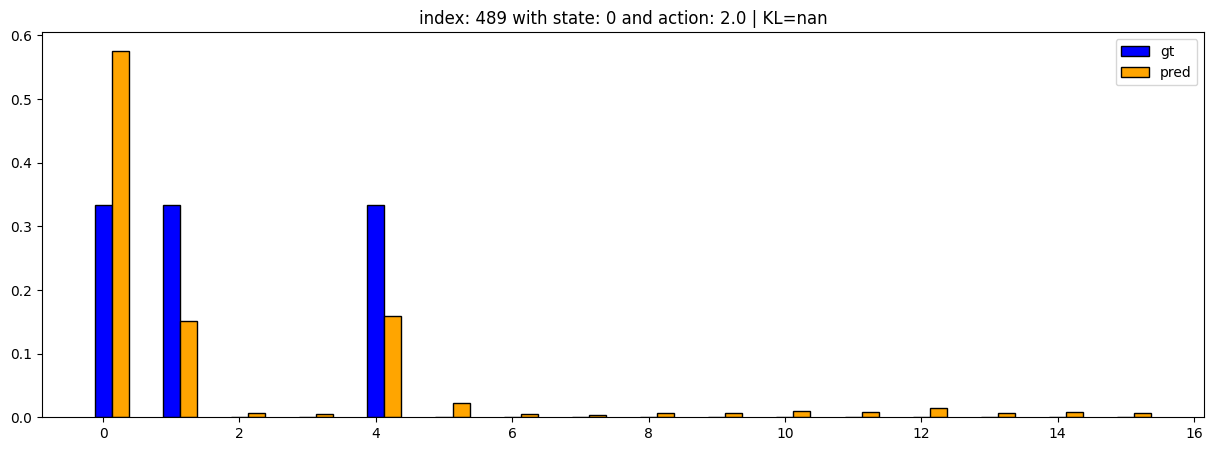

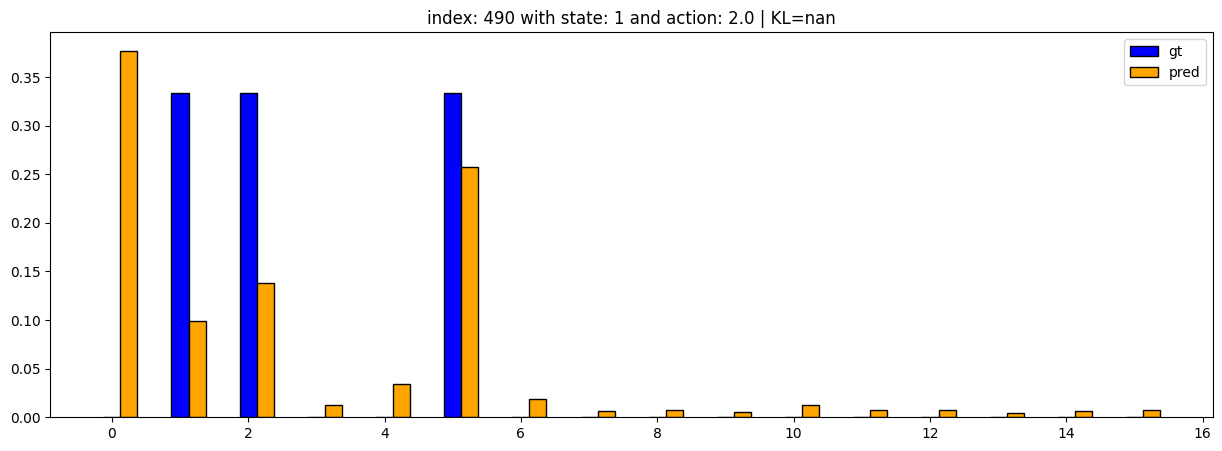

terminal state


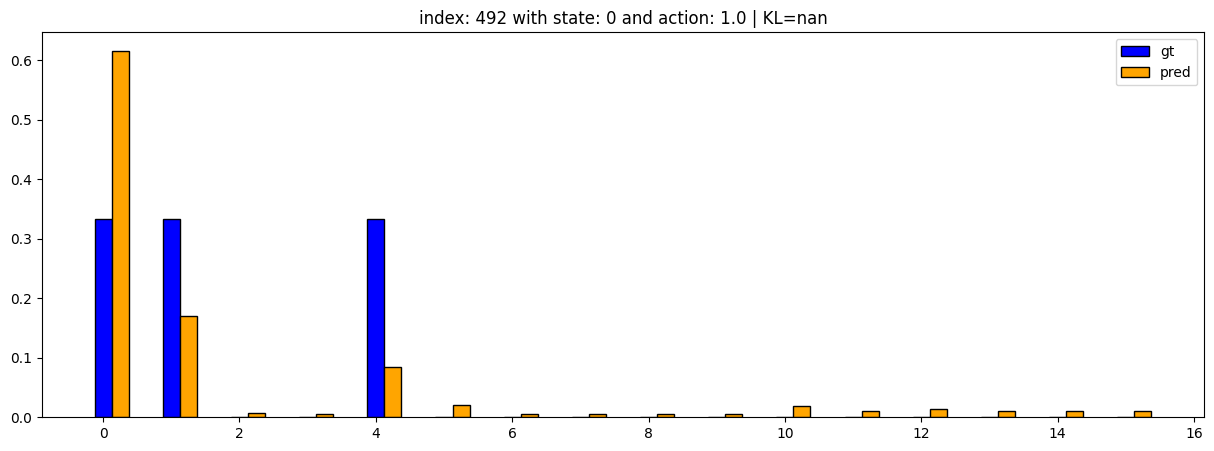

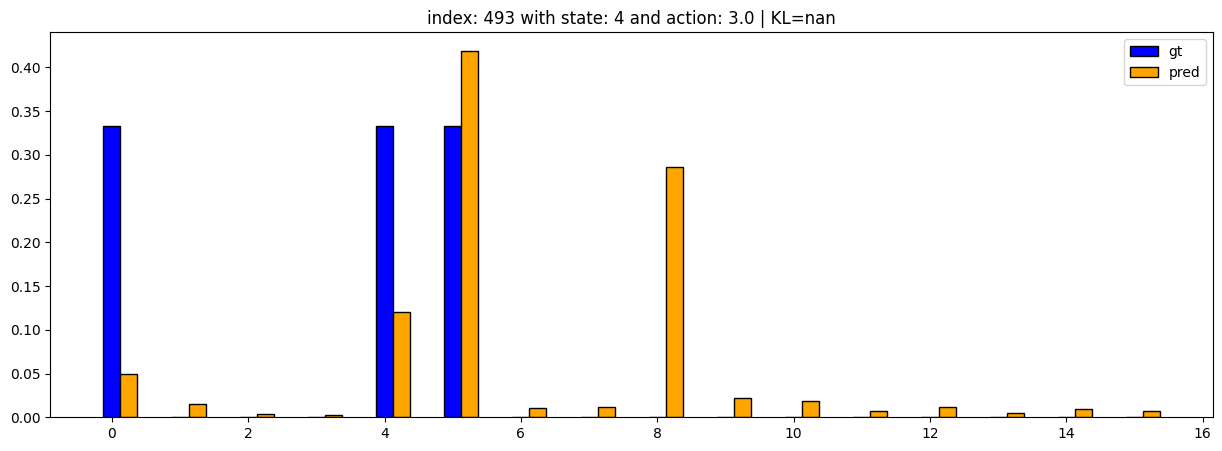

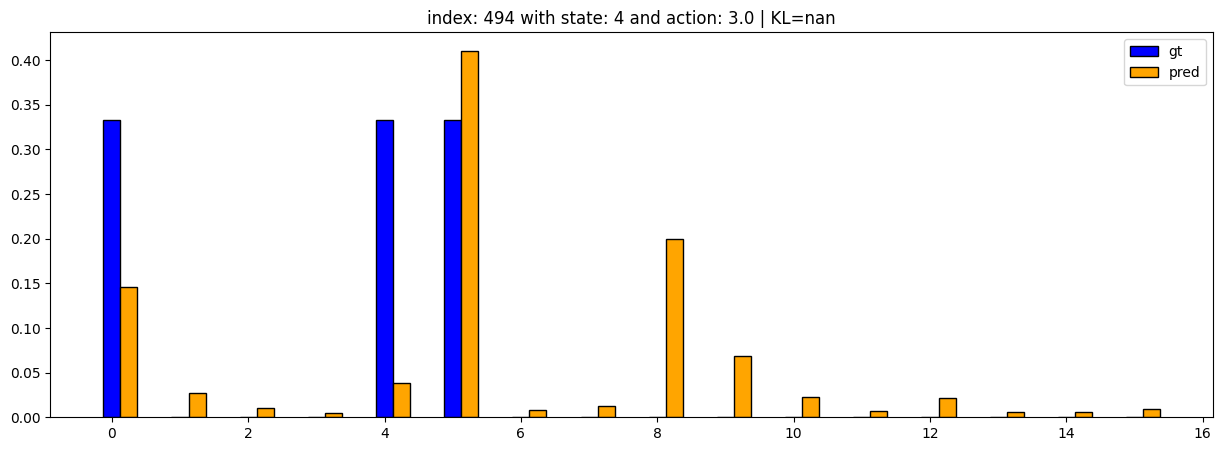

terminal state


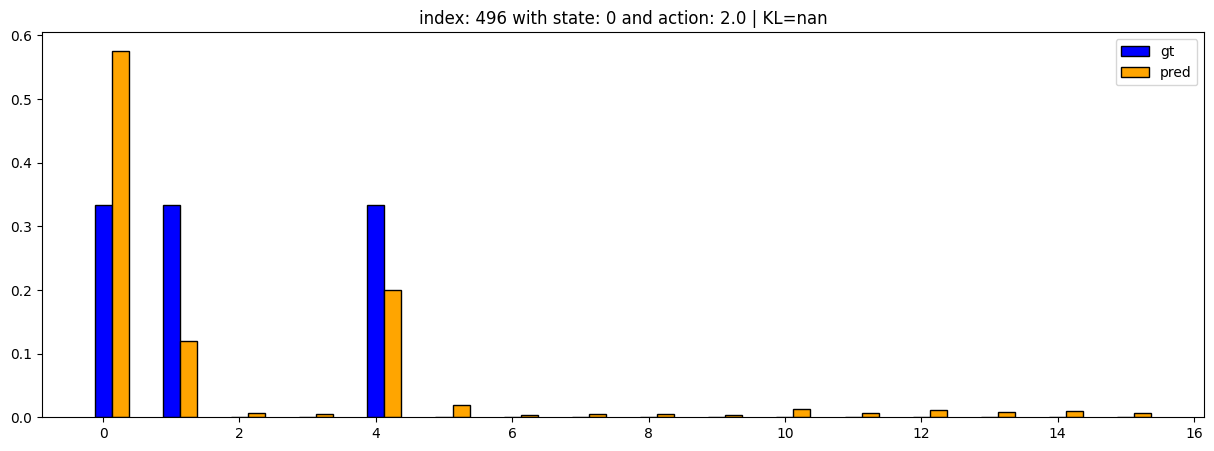

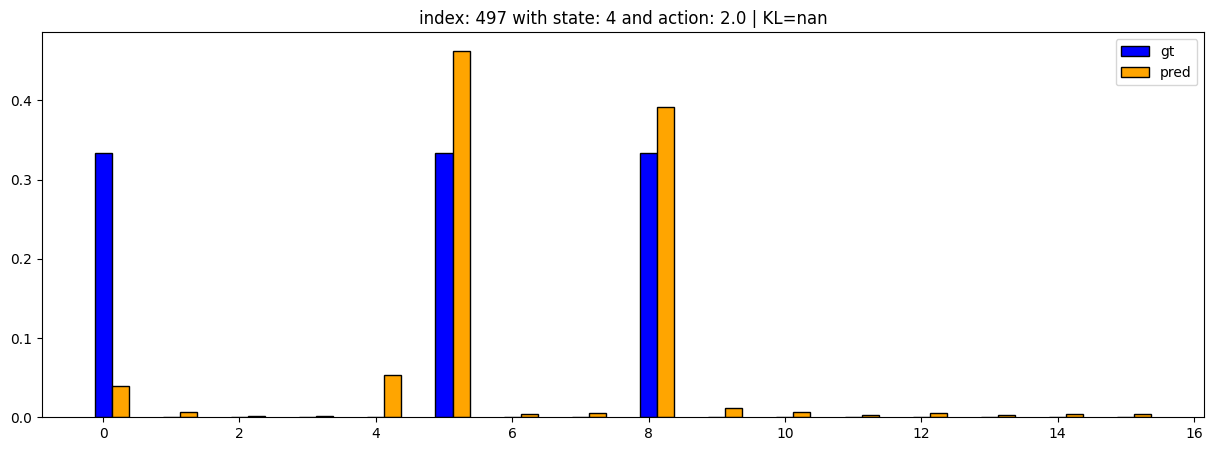

terminal state


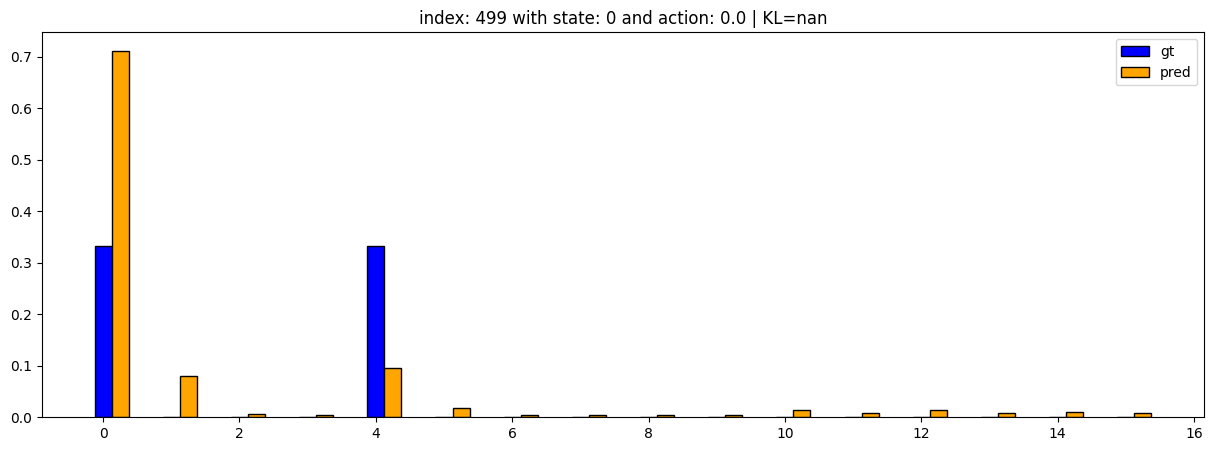

In [7]:
plot_diff(series_dict, indices=np.arange(480, 500))

## Matrix completion

In [22]:
from utils import create_ns, completion_matrix, completion_matrix_ot_breg, bins_completion, plot_matrix

In [23]:
comma_locations = np.sort(np.where(np.array(list(series_dict['full_series'])) == ',')[0])
ns = create_ns(series_dict['full_series'], comma_locations)
bins_ = bins_completion(series_dict['PDF_list'])

In [43]:
series_dict['full_series']

'150,150,150,150,150,150,150,150,365,365,150,365,365,580,365,365,365,365,419,150,150,150,203,150,150,203,150,203,257,311,257,311,257,473,419,150,150,365,580,365,150,150,365,580,634,850,634,580,796,150,150,150,150,150,365,580,580,634,688,742,150,203,150,150,203,257,473,526,150,150,365,580,580,580,796,150,150,150,203,203,419,150,150,365,419,150,365,580,634,688,742,150,150,203,150,365,580,365,580,796,'

In [42]:
sorted(set(series_dict['full_series']))

[',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [26]:
ps, hashmap = completion_matrix_ot_breg(bins_,ns,statistics['discrete_BT_loss'], reg=5e-3)
ps2, hashmap2 = completion_matrix(bins_,ns,statistics['discrete_BT_loss'])

/home/abenechehab/llmICL/utils.py:32: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = np.where(non_zero_sums_mask, np.true_divide(prob, row_sums), prob)


after filling: 0
fill borders: 0
after normalize: 0
fill borders 2: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:39<00:00,  3.07s/it]


after ot: 0
after last normalize: 0


<BarContainer object of 1000 artists>

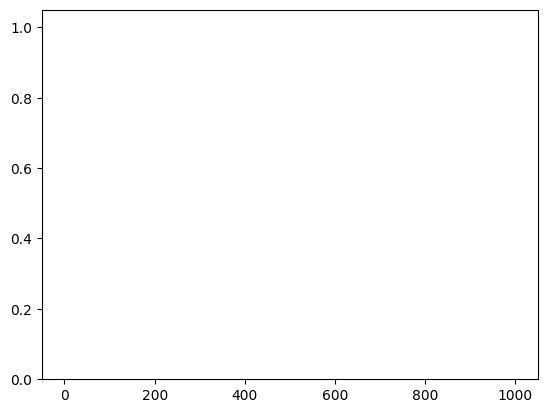

In [28]:
plt.bar(np.arange(1000), ps[5])

OT completion


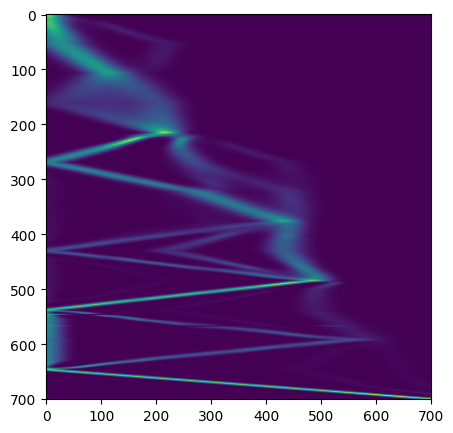

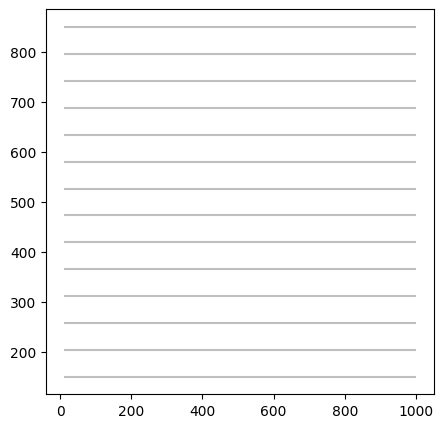

No completion


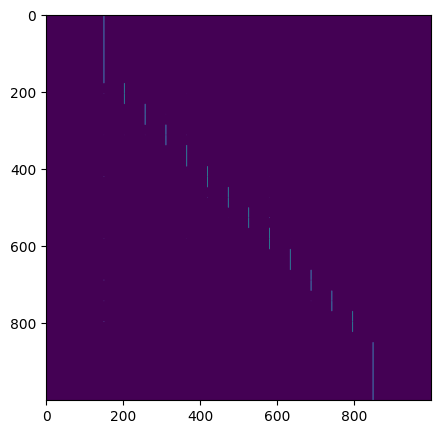

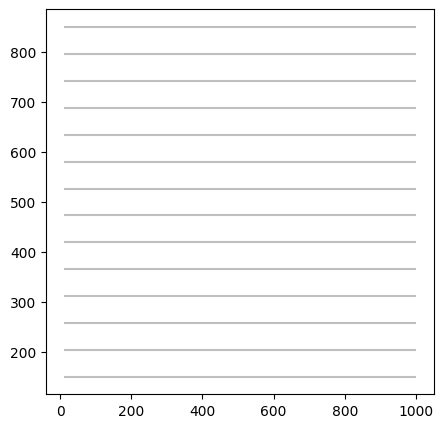

In [29]:
print(f"OT completion")
plt.figure(figsize=(5,5))
plt.imshow(ps[149:850,149:850])
plt.show()

plt.figure(figsize=(5,5))
plot_matrix(hashmap)
plt.show()

print(f"No completion")
plt.figure(figsize=(5,5))
plt.imshow(ps2)
plt.show()

plt.figure(figsize=(5,5))
plot_matrix(hashmap2)
plt.show()

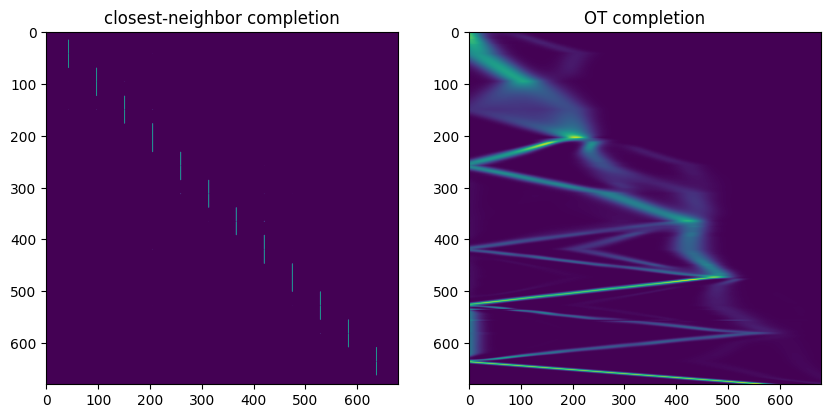

In [30]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(ps2[160:840,160:840])
plt.title("closest-neighbor completion")

plt.subplot(1,2,2)
plt.imshow(ps[160:840,160:840])
plt.title("OT completion")

plt.show()

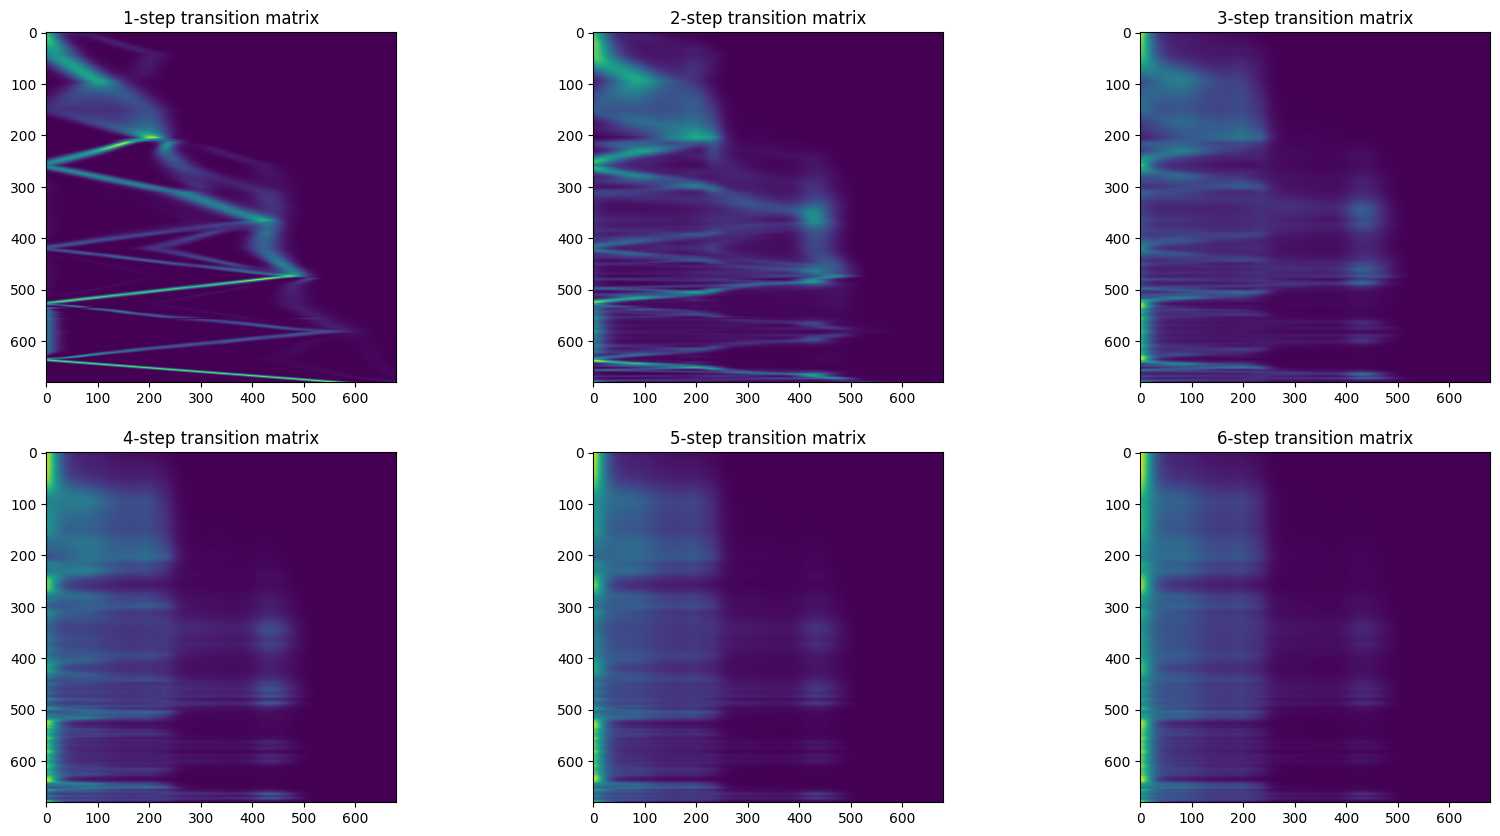

In [31]:
plt.figure(figsize=(20,10))
for power in range(1,7):
    plt.subplot(2,3,power)
    plt.imshow(np.linalg.matrix_power(ps,power)[160:840,160:840])
    plt.title(f"{power}-step transition matrix")
plt.show()

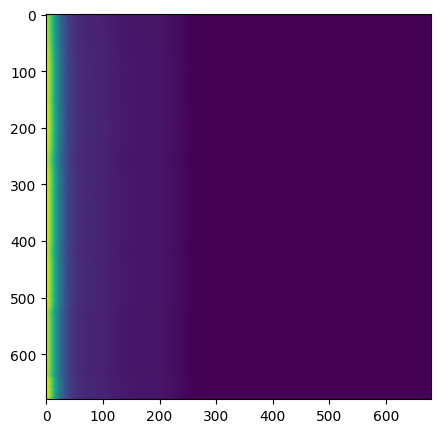

In [41]:
plt.figure(figsize=(5,5))
plt.imshow(np.linalg.matrix_power(ps,2000)[160:840,160:840])
plt.show()